In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import pandas as pd
import pickle
import lfpykit
#from lfpykit.eegmegcalc import NYHeadModel
from lfpykit.eegmegcalc import FourSphereVolumeConductor
#import LFPy
from scipy import signal as ss

In [2]:
%matplotlib inline

In [3]:
def bandPassFilter(signal,low=0.1, high=130.):
	order = 2
	b, a = ss.butter(order, [low,high],btype='bandpass',fs=fs)
	y = ss.filtfilt(b, a, signal)
	return y

Calculate EEG/MEG signals from simulation data

In [4]:
file = open('data/ASSR_test/test_data2.pkl','rb')
data = pickle.load(file)

In [6]:
print(data['simData'].keys())
print(np.shape(data['simData']['dipoleSum']))

dict_keys(['LFP', 'spkt', 'spkid', 'dipoleSum', 't', 'popRates', 'avgRate'])
(60000, 3)


In [7]:
dp = data['simData']['dipoleSum']

In [8]:
print(dp)

[[ 2.76667083e+02 -3.73190004e+03  9.88976636e-13]
 [ 2.38610685e+02 -3.70391673e+03 -1.63244964e-12]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 ...
 [-1.40775376e+05 -1.14030191e+06  2.82581400e-11]
 [-1.40015476e+05 -1.14035926e+06  2.68035329e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [13]:
# FOUR SPHERE MODEL
radii = [79000., 80000., 85000., 90000.]  # (µm)
sigmas = [0.47, 1.71, 0.02, 0.41]  # (S/m) from Mazza et al., PLoS Comp Biol, 2023
#sigmas = [0.047, 0.171, 0.02, 0.041]  # (S/m) 
r_electrodes = np.array([[0., 0., 90000.]])#, [0., 85000., 0.]]) # (µm)
pos = np.array([0., 0., 78275.])
#L23_pos = np.array([0., 0., 72500.])
sphere_model = FourSphereVolumeConductor(r_electrodes,radii, sigmas)
# # current dipole moment
#p = dp
# # compute potential
signal = sphere_model.get_dipole_potential(dp.transpose(), pos)  # (mV)

In [14]:
np.save('Test-EEG-Signal.npy',signal)

In [30]:
time = np.arange(1000,6000,6000/(np.shape(signal)[1])) 
eeg = signal[0]
dt = 0.1
fs = 1000./dt
startindex = int(1000*(1./dt))

In [31]:
print(np.shape(signal))
print(np.shape(time))
print(np.shape(eeg[startindex:]))

(1, 60000)
(50000,)
(50000,)


In [32]:
nperseg = int(fs/2)
eeg_filt = bandPassFilter(eeg[startindex:])
eeg_freq, eeg_ps = ss.welch(eeg_filt, fs=fs, nperseg=nperseg, window='hann')


Text(0, 0.5, 'Power (V^2/Hz)')

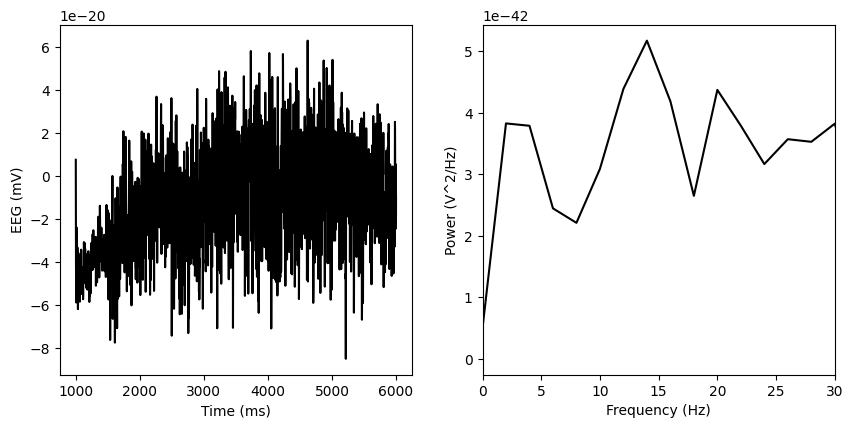

In [33]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax1.plot(time, eeg_filt, c='k')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('EEG (mV)')
ax2 = fig.add_subplot(222)
ax2.plot(eeg_freq, eeg_ps, c='k')
ax2.set_xlim(0,30)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Power (V^2/Hz)')

#plt.savefig('EEG-Signal-PSD.png', dpi=200,bbox_inches = "tight")